# SVHN Recognition
The Dataset: http://ufldl.stanford.edu/housenumbers/

In [0]:
!pip install -U -q PyDrive
!pip install -q keras

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import pandas
import numpy

In [0]:
import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

In [0]:
from keras.models import Sequential, Model
from keras.optimizers import SGD, RMSprop, Adam, Nadam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D 
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D

In [27]:
from keras import __version__
print('keras version:', __version__)

keras version: 2.1.3


In [31]:
!ls

datalab


# Load & Explore the Data

In [0]:
project_id = 'nodal-bison-150504'
bucket_name = 'symbol_classification_sets'

In [36]:
!gsutil cp gs://{bucket_name}/svhn_train_images2.csv /tmp/svhn_train_images2.csv

Copying gs://symbol_classification_sets/svhn_train_images2.csv...
\ [1 files][244.6 MiB/244.6 MiB]                                                
Operation completed over 1 objects/244.6 MiB.                                    


In [30]:
!gsutil cp gs://{bucket_name}/svhn_extra_images2.csv /tmp/svhn_extra_images2.csv

Copying gs://symbol_classification_sets/svhn_extra_images2.csv...
- [1 files][244.8 MiB/244.8 MiB]                                                
Operation completed over 1 objects/244.8 MiB.                                    


In [32]:
!gsutil cp gs://{bucket_name}/svhn_test_images2.csv /tmp/svhn_test_images2.csv

Copying gs://symbol_classification_sets/svhn_test_images2.csv...
\ [1 files][112.8 MiB/112.8 MiB]                                                
Operation completed over 1 objects/112.8 MiB.                                    


In [33]:
!gsutil cp gs://{bucket_name}/svhn_train_labels.csv /tmp/svhn_train_labels.csv

Copying gs://symbol_classification_sets/svhn_train_labels.csv...
- [1 files][412.3 KiB/412.3 KiB]                                                
Operation completed over 1 objects/412.3 KiB.                                    


In [34]:
!gsutil cp gs://{bucket_name}/svhn_extra_labels.csv /tmp/svhn_extra_labels.csv

Copying gs://symbol_classification_sets/svhn_extra_labels.csv...
/ [1 files][402.0 KiB/402.0 KiB]                                                
Operation completed over 1 objects/402.0 KiB.                                    


In [35]:
!gsutil cp gs://{bucket_name}/svhn_test_labels.csv /tmp/svhn_test_labels.csv

Copying gs://symbol_classification_sets/svhn_test_labels.csv...
/ [1 files][188.4 KiB/188.4 KiB]                                                
Operation completed over 1 objects/188.4 KiB.                                    


In [0]:
train_images = pandas.read_csv('/tmp/svhn_train_images2.csv')
train_labels = pandas.read_csv('/tmp/svhn_train_labels.csv')

test_images = pandas.read_csv('/tmp/svhn_test_images2.csv')
test_labels = pandas.read_csv('/tmp/svhn_test_labels.csv')

extra_images = pandas.read_csv('/tmp/svhn_extra_images2.csv')
extra_labels = pandas.read_csv('/tmp/svhn_extra_labels.csv')

In [38]:
test_images.ix[:10,:10]

,filename,0,1,2,3,4,5,6,7,8
0,5502.png,0.731729,0.731729,0.731729,0.732859,0.732859,0.732859,0.732859,0.749439,0.768643
1,1166.png,0.605008,0.630882,0.635082,0.611831,0.572169,0.529757,0.521914,0.549365,0.584659
2,506.png,0.194851,0.167078,0.128478,0.133976,0.132525,0.134549,0.133098,0.128898,0.128898
3,6408.png,0.357149,0.359663,0.360792,0.364714,0.365565,0.372235,0.373812,0.376114,0.380718
4,12991.png,0.588059,0.666447,0.687016,0.699910,0.708200,0.707753,0.701529,0.699910,0.701765
5,1340.png,0.530259,0.530259,0.530259,0.526337,0.526337,0.534627,0.542918,0.548459,0.548906
6,6876.png,0.498114,0.497667,0.495600,0.499522,0.499969,0.501588,0.499733,0.496984,0.493063
7,7485.png,0.244090,0.250592,0.165278,0.166965,0.216435,0.267525,0.289267,0.275882,0.260643
8,12741.png,0.188620,0.188384,0.187255,0.188149,0.193243,0.197165,0.195992,0.193816,0.192153
9,607.png,0.360380,0.384592,0.394737,0.395867,0.400918,0.395867,0.391945,0.388471,0.396761


In [39]:
test_labels.ix[:10,:]

,filename,0,1,2,3,4
0,5502.png,10.0,10.0,1.0,7.0,1.0
1,1166.png,10.0,10.0,10.0,1.0,7.0
2,506.png,10.0,10.0,10.0,2.0,8.0
3,6408.png,10.0,10.0,10.0,4.0,3.0
4,12991.png,10.0,10.0,10.0,7.0,0.0
5,1340.png,10.0,10.0,10.0,10.0,4.0
6,6876.png,10.0,10.0,10.0,10.0,9.0
7,7485.png,10.0,10.0,10.0,7.0,2.0
8,12741.png,10.0,10.0,2.0,0.0,3.0
9,607.png,10.0,10.0,10.0,4.0,0.0


In [0]:
train_images = train_images.ix[:,1:].as_matrix().astype('float32')
train_labels = train_labels.ix[:,1:].as_matrix().astype('int16')

test_images = test_images.ix[:,1:].as_matrix().astype('float32')
test_labels = test_labels.ix[:,1:].as_matrix().astype('int16')

extra_images = extra_images.ix[:,1:].as_matrix().astype('float32')
extra_labels = extra_labels.ix[:,1:].as_matrix().astype('int16')

Label:  [10 10  1  3  5]


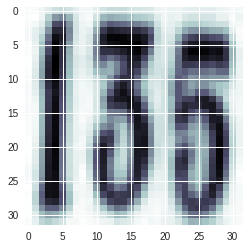

In [41]:
print('Label: ', extra_labels[100])
plt.imshow(extra_images[100].reshape(32,32), cmap=plt.cm.bone);

In [0]:
def digit_to_categorical(data):
    n = data.shape[1]
    data_cat = numpy.empty([len(data), n, 11])    
    for i in range(n):
        data_cat[:, i] = to_categorical(data[:, i], num_classes=11)        
    return data_cat

In [43]:
x_train = numpy.concatenate((train_images.reshape(-1, 32, 32, 1),
                             test_images.reshape(-1, 32, 32, 1)),
                            axis=0)
y_train = numpy.concatenate((digit_to_categorical(train_labels),
                             digit_to_categorical(test_labels)),
                            axis=0)

x_valid = extra_images.reshape(-1, 32, 32, 1)
y_valid = digit_to_categorical(extra_labels)

n = int(len(x_valid)/2)
x_test, y_test = x_valid[:n], y_valid[:n]
x_valid, y_valid = x_valid[n:], y_valid[n:]

x_train.shape, x_test.shape, x_valid.shape, \
y_train.shape, y_test.shape, y_valid.shape

((19000, 32, 32, 1),
 (6500, 32, 32, 1),
 (6500, 32, 32, 1),
 (19000, 5, 11),
 (6500, 5, 11),
 (6500, 5, 11))

In [0]:
y_train_list = [y_train[:, i] for i in range(5)]
y_test_list = [y_test[:, i] for i in range(5)]
y_valid_list = [y_valid[:, i] for i in range(5)]

# Build the Model

In [0]:
def cnn_model():    
    model_input = Input(shape=(32, 32, 1))
    x = BatchNormalization()(model_input)
        
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(model_input)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)       
    x = Conv2D(64, (3, 3), activation='relu')(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), activation='relu')(x)    
    x = Dropout(0.25)(x)
              
    x = Flatten()(x)
    
    x = Dense(512, activation='relu')(x)    
    x = Dropout(0.5)(x)
    
    y1 = Dense(11, activation='softmax')(x)
    y2 = Dense(11, activation='softmax')(x)
    y3 = Dense(11, activation='softmax')(x)
    y4 = Dense(11, activation='softmax')(x)
    y5 = Dense(11, activation='softmax')(x)
    
    model = Model(input=model_input, output=[y1, y2, y3, y4, y5])

    model.compile(loss='categorical_crossentropy', 
                  optimizer='nadam', 
                  metrics=['accuracy'])
    return model

In [0]:
cnn_model = cnn_model()
cnn_checkpointer = ModelCheckpoint(filepath='weights.best.svhn.cnn.hdf5', 
                                   verbose=2, save_best_only=True)

In [47]:
cnn_history = cnn_model.fit(x_train, y_train_list, 
                            validation_data=(x_valid, y_valid_list), 
                            epochs=100, batch_size=128, verbose=0, 
                            callbacks=[cnn_checkpointer])


Epoch 00001: val_loss improved from inf to 7.10238, saving model to weights.best.svhn.cnn.hdf5

Epoch 00002: val_loss improved from 7.10238 to 6.48660, saving model to weights.best.svhn.cnn.hdf5

Epoch 00003: val_loss improved from 6.48660 to 6.13102, saving model to weights.best.svhn.cnn.hdf5

Epoch 00004: val_loss improved from 6.13102 to 5.46173, saving model to weights.best.svhn.cnn.hdf5

Epoch 00005: val_loss improved from 5.46173 to 4.69716, saving model to weights.best.svhn.cnn.hdf5

Epoch 00006: val_loss improved from 4.69716 to 3.95886, saving model to weights.best.svhn.cnn.hdf5

Epoch 00007: val_loss improved from 3.95886 to 3.57155, saving model to weights.best.svhn.cnn.hdf5

Epoch 00008: val_loss improved from 3.57155 to 3.33676, saving model to weights.best.svhn.cnn.hdf5

Epoch 00009: val_loss improved from 3.33676 to 3.10976, saving model to weights.best.svhn.cnn.hdf5

Epoch 00010: val_loss improved from 3.10976 to 3.04152, saving model to weights.best.svhn.cnn.hdf5

Epo


Epoch 00047: val_loss did not improve

Epoch 00048: val_loss improved from 1.71563 to 1.71549, saving model to weights.best.svhn.cnn.hdf5

Epoch 00049: val_loss improved from 1.71549 to 1.69818, saving model to weights.best.svhn.cnn.hdf5

Epoch 00050: val_loss did not improve

Epoch 00051: val_loss did not improve

Epoch 00052: val_loss did not improve

Epoch 00053: val_loss improved from 1.69818 to 1.66962, saving model to weights.best.svhn.cnn.hdf5

Epoch 00054: val_loss did not improve

Epoch 00055: val_loss did not improve

Epoch 00056: val_loss did not improve

Epoch 00057: val_loss did not improve

Epoch 00058: val_loss improved from 1.66962 to 1.66827, saving model to weights.best.svhn.cnn.hdf5

Epoch 00059: val_loss did not improve

Epoch 00060: val_loss did not improve

Epoch 00061: val_loss improved from 1.66827 to 1.64443, saving model to weights.best.svhn.cnn.hdf5

Epoch 00062: val_loss did not improve

Epoch 00063: val_loss did not improve

Epoch 00064: val_loss did not i

In [51]:
cnn_model.load_weights('weights.best.svhn.cnn.hdf5')
cnn_scores = cnn_model.evaluate(x_test, y_test_list, verbose=0)

print("CNN Model. \n")
print("Scores: \n" , (cnn_scores))
print("First digit. Accuracy: %.2f%%" % (cnn_scores[6]*100))
print("Second digit. Accuracy: %.2f%%" % (cnn_scores[7]*100))
print("Third digit. Accuracy: %.2f%%" % (cnn_scores[8]*100))
print("Fourth digit. Accuracy: %.2f%%" % (cnn_scores[9]*100))
print("Fifth digit. Accuracy: %.2f%%" % (cnn_scores[10]*100))

print(cnn_model.summary())

CNN Model. 

Scores: 
 [1.6595240767552302, 0.004725767422044206, 0.1470861965172494, 0.6150185376680815, 0.40719676424906803, 0.4854968117200411, 0.9995384615384615, 0.965076923076923, 0.8267692307692308, 0.8843076923076924, 0.8558461538461538]
First digit. Accuracy: 99.95%
Second digit. Accuracy: 96.51%
Third digit. Accuracy: 82.68%
Fourth digit. Accuracy: 88.43%
Fifth digit. Accuracy: 85.58%
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pool

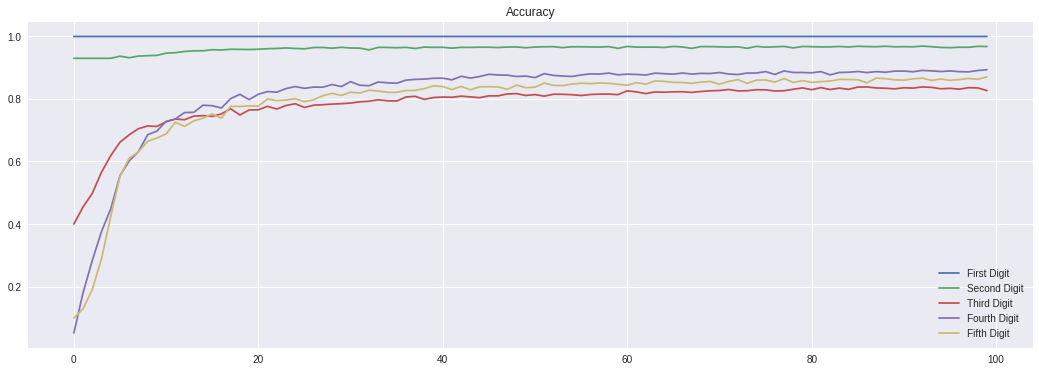

In [49]:
plt.figure(figsize=(18, 6))

plt.plot(cnn_history.history['val_dense_2_acc'], label = 'First Digit')
plt.plot(cnn_history.history['val_dense_3_acc'], label = 'Second Digit')
plt.plot(cnn_history.history['val_dense_4_acc'], label = 'Third Digit')
plt.plot(cnn_history.history['val_dense_5_acc'], label = 'Fourth Digit')
plt.plot(cnn_history.history['val_dense_6_acc'], label = 'Fifth Digit')

plt.legend()
plt.title('Accuracy');

In [50]:
avg_accuracy = sum([cnn_scores[i] for i in range(6, 11)])/5
print("CNN Model. Average Accuracy: %.2f%%" % (avg_accuracy*100))

CNN Model. Average Accuracy: 90.63%
